# Statistiques descriptives

In [1]:
from functions import *

Chargement et nettoyage des données

In [2]:
# Charger les données depuis entities.json
with open("../data/entities.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Load labels
tokens, list_tags, noms_tags = load_labels("../data/tokens.yml")

# Appliquer les fonctions clean_text et normalize_text à chaque élément de data
data = {key: clean_text(value, list_tags) for key, value in data.items()}

# Séparer le texte ligne par ligne (donc pour chaque personne recensée)
data_lines = load_lines(data)

print("Nombre de tags :", len(tokens))
print("Nombre d'entrées dans le fichier entities.json:", len(data))
print("Nombre de lignes dans tous les documents au total :", len(data_lines))

Nombre de tags : 14
Nombre d'entrées dans le fichier entities.json: 1218
Nombre de lignes dans tous les documents au total : 25448


In [3]:
# Construction d'une expression régulière pour rechercher les motifs correspondants à un espace suivi d'un tag
pattern = "|".join(["\s(?={})".format(re.escape(tag)) for tag in list_tags])

# création d'un dictionnaire pour stocker les mots correspondants à chaque tag
data_dict = fill_tag_dictionary(data_lines, list_tags, pattern)

# Créer un DataFrame à partir du dictionnaire
df = pd.DataFrame(data_dict)
df.rename(columns=noms_tags, inplace=True)

In [4]:
df.describe()

,age,birth_date,civil_status,education_level,employer,firstname,link,lob,maiden_name,nationality,observation,occupation,surname,surname_household
count,25448,25448,25448,25448,25448,25448,25448,25448,25448,25448,25448,25448,25448,25448
unique,249,159,7,1,1075,2374,889,2890,1,71,308,1960,8025,4105
top,,,,,,Marie,,,,,,,,
freq,9012,18104,14743,25448,22538,2758,4712,16216,25448,12134,24852,9270,6290,19808


Les colonnes 'education_level' et 'maiden_name' sont vides, nous décidons de les supprimer.

In [5]:
df.drop(columns=["education_level"], inplace=True)
df.drop(columns=["maiden_name"], inplace=True)

Les colonnes 'surname' et 'surname_household' se complètent donc nous les fusionnons

In [6]:
result2 = df.apply(check_both_not_empty, axis=1)
print(
    np.sum(result2), " lignes du dataframe ont 'surname' et 'surname_household' remplis"
)


# On fusionne les deux colonnes
df["surname"] = df.apply(
    lambda row: fusionner_colonnes(row["surname"], row["surname_household"]), axis=1
)
df.drop(columns=["surname_household"], inplace=True)

0  lignes du dataframe ont 'surname' et 'surname_household' remplis


In [7]:
df2 = df.copy()
df2.replace("", np.nan, inplace=True)
df2.describe()

# Décommenter pour afficher le tableau latex
# statistics= df2.describe().to_latex()
# print(statistics)

,age,birth_date,civil_status,employer,firstname,link,lob,nationality,observation,occupation,surname
count,16436,7344,10705,2910,24931,20736,9232,13314,596,16178,24798
unique,248,158,6,1074,2373,888,2889,70,307,1959,9464
top,2,1901,Garcon,patron,Marie,chef,idem,francaise,idem,idem,idem
freq,337,138,2824,644,2758,3022,3378,8191,88,3695,673


Statistiques sur le type de chaîne de caractères pour chaque label

In [8]:
stats_dict = {}
stats_dict_mean = {}

# On applique chaque fonction à chaque label pour calculer les statistiques descriptives
for col in df.columns:
    print(col)
    # Création d'un DataFrame pour la colonne actuelle
    stats_col = pd.DataFrame()

    # Appliquer chaque fonction à la colonne actuelle
    stats_col["longueur_chaine"] = [
        longueur_chaine(val) for val in df[col].values[df[col].values != ""]
    ]
    stats_col["nombre_mots"] = [
        nombre_mots(val) for val in df[col].values[df[col].values != ""]
    ]
    stats_col["nombre_caracteres_speciaux"] = [
        nombre_caracteres_speciaux(val) for val in df[col].values[df[col].values != ""]
    ]
    stats_col["nombre_lettres"] = [
        nombre_lettres(val) for val in df[col].values[df[col].values != ""]
    ]
    stats_col["nombre_voyelles"] = [
        nombre_voyelles(val) for val in df[col].values[df[col].values != ""]
    ]
    stats_col["nombre_consonnes"] = [
        nombre_consonnes(val) for val in df[col].values[df[col].values != ""]
    ]
    stats_dict[col] = stats_col

    s = stats_col.describe()
    s.drop(["count", "std", "25%", "50%", "75%"], inplace=True)
    latex_table = s.to_latex()
    s.drop(["min", "max"], inplace=True)
    stats_dict_mean[col] = [
        np.mean(stats_col["longueur_chaine"]),
        np.mean(stats_col["nombre_lettres"]),
        np.mean(stats_col["nombre_voyelles"]),
    ]
    print(latex_table)

age
\begin{tabular}{lrrrrrr}
\toprule
 & longueur_chaine & nombre_mots & nombre_caracteres_speciaux & nombre_lettres & nombre_voyelles & nombre_consonnes \\
\midrule
mean & 1.962947 & 1.030604 & 1.820273 & 0.112071 & 0.051046 & 0.061025 \\
min & 1.000000 & 1.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\
max & 14.000000 & 4.000000 & 4.000000 & 10.000000 & 5.000000 & 5.000000 \\
\bottomrule
\end{tabular}

birth_date
\begin{tabular}{lrrrrrr}
\toprule
 & longueur_chaine & nombre_mots & nombre_caracteres_speciaux & nombre_lettres & nombre_voyelles & nombre_consonnes \\
\midrule
mean & 3.997549 & 1.000408 & 3.994145 & 0.002996 & 0.001362 & 0.001634 \\
min & 1.000000 & 1.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\
max & 9.000000 & 3.000000 & 5.000000 & 9.000000 & 4.000000 & 5.000000 \\
\bottomrule
\end{tabular}

civil_status
\begin{tabular}{lrrrrrr}
\toprule
 & longueur_chaine & nombre_mots & nombre_caracteres_speciaux & nombre_lettres & nombre_voyelles & nombre_consonnes \\

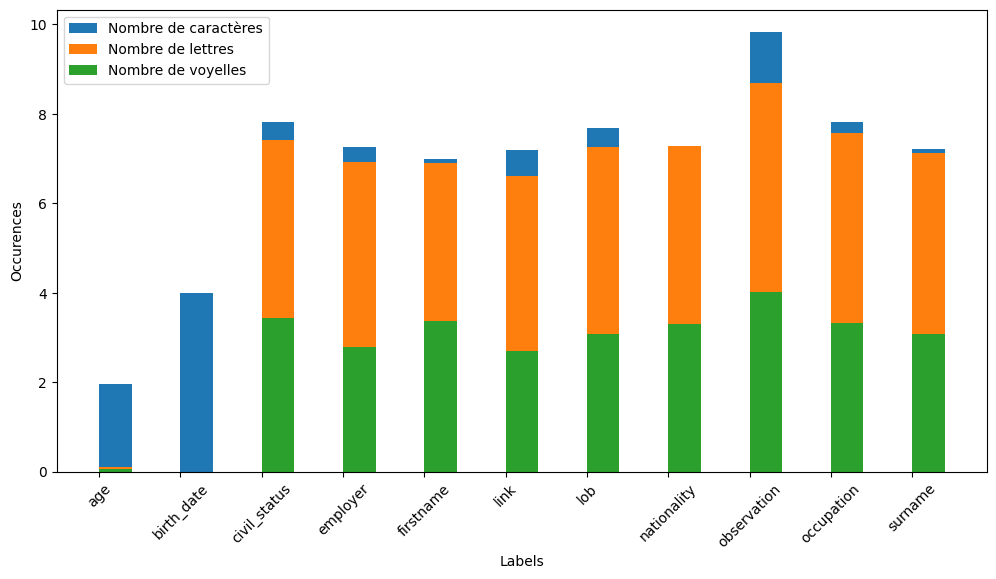

In [9]:
stats_mean = pd.DataFrame(stats_dict_mean)

X = stats_mean.columns.to_list()

X_axis = np.arange(len(X))

plt.figure(figsize=(12, 6))

plt.bar(X_axis + 0.2, stats_mean.iloc[0].to_list(), 0.4, label="Nombre de caractères")
plt.bar(X_axis + 0.2, stats_mean.iloc[1].to_list(), 0.4, label="Nombre de lettres")
plt.bar(X_axis + 0.2, stats_mean.iloc[2].to_list(), 0.4, label="Nombre de voyelles")

plt.xticks(X_axis, X, rotation=45)
plt.xlabel("Labels")
plt.ylabel("Occurences")
plt.legend()

plt.savefig("../img/barplot.png", format="png")

plt.show()

/tmp/ipykernel_130523/1591985590.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", 12)


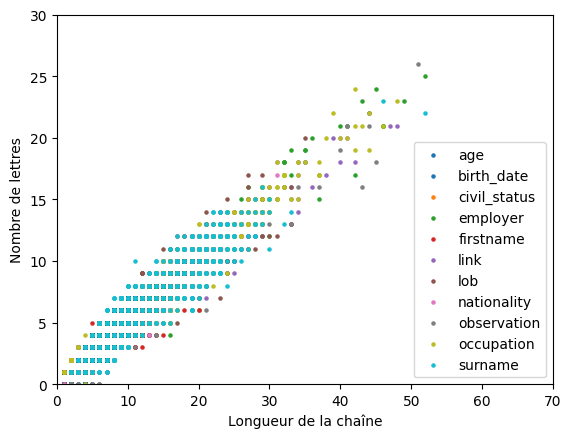

In [10]:
# Créer une liste de couleurs pour chaque colonne
colors = plt.cm.get_cmap("tab10", 12)

# Parcourir chaque colonne du dictionnaire stats_dict
for i, (column_name, column_data) in enumerate(stats_dict.items()):
    plt.scatter(
        column_data["longueur_chaine"],
        column_data["nombre_consonnes"],
        label=column_name,
        color=colors(i),
        s=5,
    )

plt.xlim(0, 70)
plt.ylim(0, 30)
plt.xlabel("Longueur de la chaîne")
plt.ylabel("Nombre de lettres")
plt.legend()

plt.savefig("../img/nuage_points.png", format="png")

plt.show()

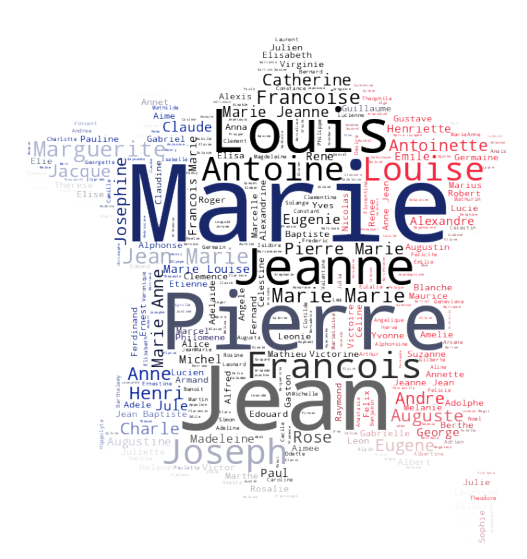

In [11]:
text = " ".join(df["firstname"].astype(str))

STOPWORDS = [x.strip() for x in open("../files/stop_word_fr.txt").readlines()]
# Charger l'image et le masque
image = np.array(Image.open("../img/france_rgb_gris.jpg"))
mask = np.array(Image.open("../img/france_rgb_gris.jpg"))

# Ajuster la transparence du masque
mask[mask == 128] = 0

# Creation du nuage de mots
wordcloud_fra = WordCloud(
    stopwords=STOPWORDS,
    background_color="rgba(255, 255, 255, 0)",
    mode="RGBA",
    max_words=1000,
    mask=mask,
    contour_color="black",
).generate(text)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7, 7])
plt.imshow(wordcloud_fra.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.savefig("../img/nuage_mots.png", format="png")

plt.show()

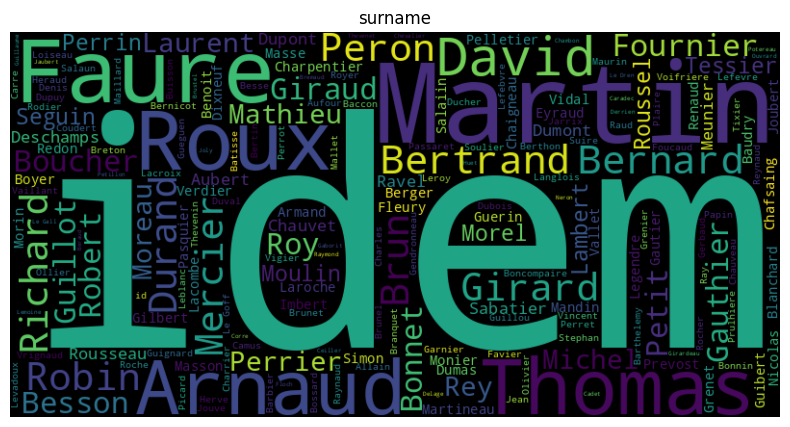

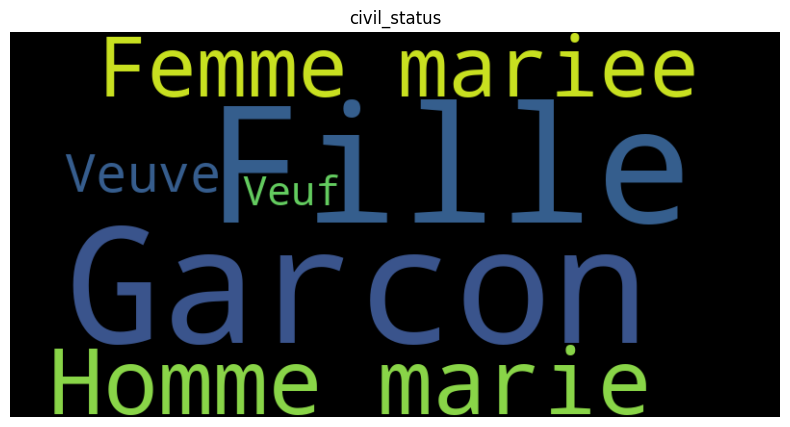

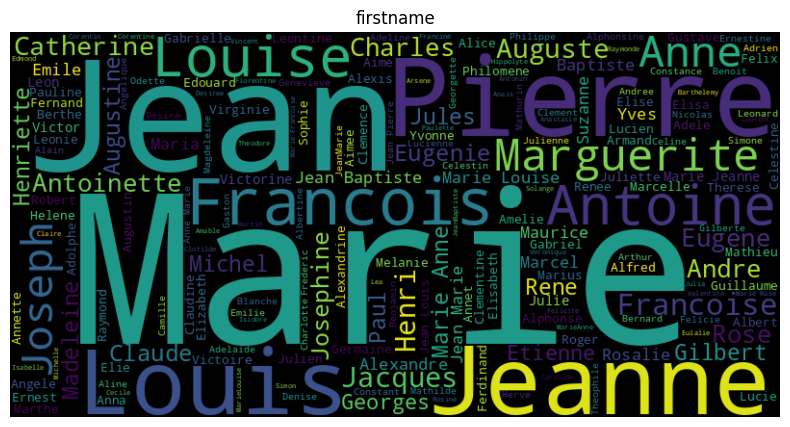

In [13]:
# Display one wordcloud for each of the most frequent classes
STOPWORDS = [x.strip() for x in open("../files/stop_word_fr.txt").readlines()]

# plot a word cloud for each category
for cat in ["surname", "civil_status", "firstname"]:
    wordcloud = WordCloud(
        width=800, height=400, stopwords=STOPWORDS
    ).generate_from_frequencies(Counter(df[cat].dropna().astype(str).tolist()))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(cat)
    plt.axis("off")
    plt.show()

On enregistre le DataFrame pour pouvoir le réutiliser dans nos modèles 

In [16]:
df.to_csv("../data/dataset.csv", index=False)